# M08: Orchestration & Lakeflow Jobs

## 8.1. The Story: Automating the Data Factory

We need to automate their daily ETL process:
- Order data ingestion at 2:00 AM
- Transformation to Silver layer
- Aggregations to Gold
- Notifications on errors

In this module, you'll learn how to create and configure Lakeflow Jobs through the UI.

---

## 8.2. Agenda

1. Introduction to Lakeflow Jobs
2. Preparing notebooks for Job (tasks)
3. [UI DEMO] Creating Multi-task Job
4. [UI DEMO] Triggers and Schedule
5. [UI DEMO] Options, Retry and Alerting
6. Practice: Widgets and Parameters
7. Practice: Passing Data Between Tasks
8. Monitoring via System Tables

---

## 8.3. Introduction to Lakeflow Jobs

**Lakeflow Jobs** (formerly Databricks Jobs) is a managed orchestration service.

### 8.3.1. When to Use Jobs?

| Scenario | Solution |
|----------|----------|
| ETL pipeline with multiple steps | Multi-task Job |
| Daily report at fixed time | Scheduled Job |
| Reaction to new files | File Arrival Trigger |
| ML training pipeline | Job with notebook tasks |
| Run Lakeflow Pipeline | Job with Pipeline task |

### 8.3.2. Jobs vs Lakeflow Declarative Pipelines

| Feature | Jobs | Lakeflow Pipelines |
|---------|------|-----|
| Orchestration | General | ETL only |
| Dependencies | Manual configuration | Automatic (DAG) |
| Data Quality | Custom code | Built-in expectations |
| Flexibility | High | Opinionated |

**Best Practice**: Use Lakeflow Pipelines for ETL pipelines, Jobs for orchestrating Pipelines + other tasks.

---

### 8.3.3. Task Types in Lakeflow Jobs

| Task Type | Description | Use Case |
|-----------|-------------|----------|
| Notebook | Run a Databricks notebook | ETL logic, ML training |
| Pipeline | Run a Lakeflow Declarative Pipeline | Streaming/batch pipelines |
| Python Script | Run a Python file | Utility scripts |
| SQL | Run a SQL query | DDL, reporting queries |
| JAR | Run a Java/Scala JAR | Legacy Spark jobs |
| Spark Submit | Submit a Spark application | Custom Spark apps |
| If/Else Condition | Branch based on condition | Conditional workflows |
| For Each | Iterate over a list | Parameterized batch runs |

**Repair Runs:**
- When a job fails, you can **repair** it instead of re-running from scratch
- Repair re-runs only the **failed and downstream tasks**
- Successfully completed tasks are **skipped**
- This saves compute cost and time

**Exam Note:** Know that repair runs skip already-successful tasks. Also know that If/Else and For Each enable conditional and iterative workflows.

## 8.4. Preparing Notebooks for Job

Below are 3 simple notebooks that we'll use in the demo.

**Instructions**: 
1. Create folder `/Workspace/Users/<your-email>/jobs_demo/`
2. Copy each of the following code snippets to a separate notebook

---

### 8.4.1. Task 1: Validate Source (`task_01_validate`)

In [0]:
# TASK 1: Validate Source Data
# Copy this code to notebook: task_01_validate

# Parameters from Job
dbutils.widgets.text("source_table", "samples.nyctaxi.trips")
dbutils.widgets.text("min_rows", "100")

source_table = dbutils.widgets.get("source_table")
min_rows = int(dbutils.widgets.get("min_rows"))

# Validation
df = spark.table(source_table)
row_count = df.count()

if row_count < min_rows:
    raise Exception(f"Validation FAILED: {row_count} rows < {min_rows} minimum")

# Return result to next task
import json
dbutils.notebook.exit(json.dumps({
    "status": "SUCCESS",
    "source_table": source_table,
    "row_count": row_count
}))

### 8.4.2. Task 2: Transform Data (`task_02_transform`)

In [0]:
# TASK 2: Transform Data
# Copy this code to notebook: task_02_transform

from pyspark.sql.functions import *
import json

# Parameters
dbutils.widgets.text("source_table", "samples.nyctaxi.trips")
dbutils.widgets.text("run_date", "")

source_table = dbutils.widgets.get("source_table")
run_date = dbutils.widgets.get("run_date") or str(current_date())

# Get result from previous task (optional)
try:
    prev_result = dbutils.jobs.taskValues.get(
        taskKey="validate",
        key="returnValue",
        default="{}"
    )
    prev_data = json.loads(prev_result)
    print(f"Previous task result: {prev_data}")
except:
    print("Running standalone (no previous task)")

# Transformation
print(f"Transforming: {source_table}")

df = spark.table(source_table)

df_transformed = (
    df
    .withColumn("trip_duration_minutes", 
                round((col("tpep_dropoff_datetime").cast("long") - 
                       col("tpep_pickup_datetime").cast("long")) / 60, 2))
    .withColumn("cost_per_mile", 
                when(col("trip_distance") > 0, 
                     round(col("fare_amount") / col("trip_distance"), 2))
                .otherwise(0))
    .withColumn("processing_date", lit(run_date))
)

row_count = df_transformed.count()
print(f"Transformed {row_count} rows")

df_transformed.select(
    "trip_distance", "fare_amount", "trip_duration_minutes", "cost_per_mile"
).show(5)

# Return result
dbutils.notebook.exit(json.dumps({
    "status": "SUCCESS",
    "rows_transformed": row_count
}))

### 8.4.3. Task 3: Generate Report (`task_03_report`)

In [0]:
# TASK 3: Generate Report
# Copy this code to notebook: task_03_report

from pyspark.sql.functions import *
import json
from datetime import datetime

# Parameters
dbutils.widgets.text("source_table", "samples.nyctaxi.trips")

source_table = dbutils.widgets.get("source_table")

# Aggregations
df = spark.table(source_table)

report = df.agg(
    count("*").alias("total_trips"),
    round(sum("fare_amount"), 2).alias("total_revenue"),
    round(avg("fare_amount"), 2).alias("avg_fare"),
    round(avg("trip_distance"), 2).alias("avg_distance"),
    round(max("fare_amount"), 2).alias("max_fare")
).collect()[0]

# Display report
print("\n" + "="*50)
print("DAILY REPORT")
print("="*50)
print(f"Avg Fare:       ${report.avg_fare:.2f}")
print(f"Avg Distance:   {report.avg_distance:.2f} miles")
print(f"Max Fare:       ${report.max_fare:.2f}")
print("="*50)
print(f"Generated at:   {datetime.now()}")
print("="*50 + "\n")

# Return result
dbutils.notebook.exit(json.dumps({
    "status": "SUCCESS",
    "total_trips": report.total_trips,
    "total_revenue": float(report.total_revenue)
}))

## 8.5. [UI DEMO] Creating Multi-task Job 



### 8.5.1. Checklist for instructor:

**Step 1: Create new Job**
- [ ] Workflows → Create Job
- [ ] Name: `Demo_ETL_Pipeline`

![Screenshot](<../../assets/images/93c107ca21a54aab98249cf47db0337d.png>)


- [ ] Cluster Job: Create new cluster job

![Screenshot](<../../assets/images/a967557a143a40c0ac7ed26ce469866a.png>)

**Step 2: Add Task 1 (Validate)**
- [ ] Task name: `validate`
- [ ] Type: Notebook
- [ ] Path: `/Workspace/.../task_01_validate`
- [ ] Cluster: Serverless or new Job Cluster
- [ ] Parameters: `source_table` = `samples.nyctaxi.trips`

![Screenshot](<../../assets/images/214b868309344df3a6e81f3cc2a84c13.png>)

**Step 3: Add Task 2 (Transform)**
- [ ] Task name: `transform`
- [ ] Depends on: `validate`
- [ ] Path: `/Workspace/.../task_02_transform`
- [ ] Parameters: `source_table` = `samples.nyctaxi.trips`

**Step 4: Add Task 3 (Report)**
- [ ] Task name: `report`
- [ ] Depends on: `transform`
- [ ] Path: `/Workspace/.../task_03_report`

![Screenshot](<../../assets/images/a3cc387f44de4247bf275bdbd38efb84.png>)

**Step 5: Run Job**
- [ ] Run now
- [ ] Show: DAG visualization
- [ ] Show: Task logs and output



---
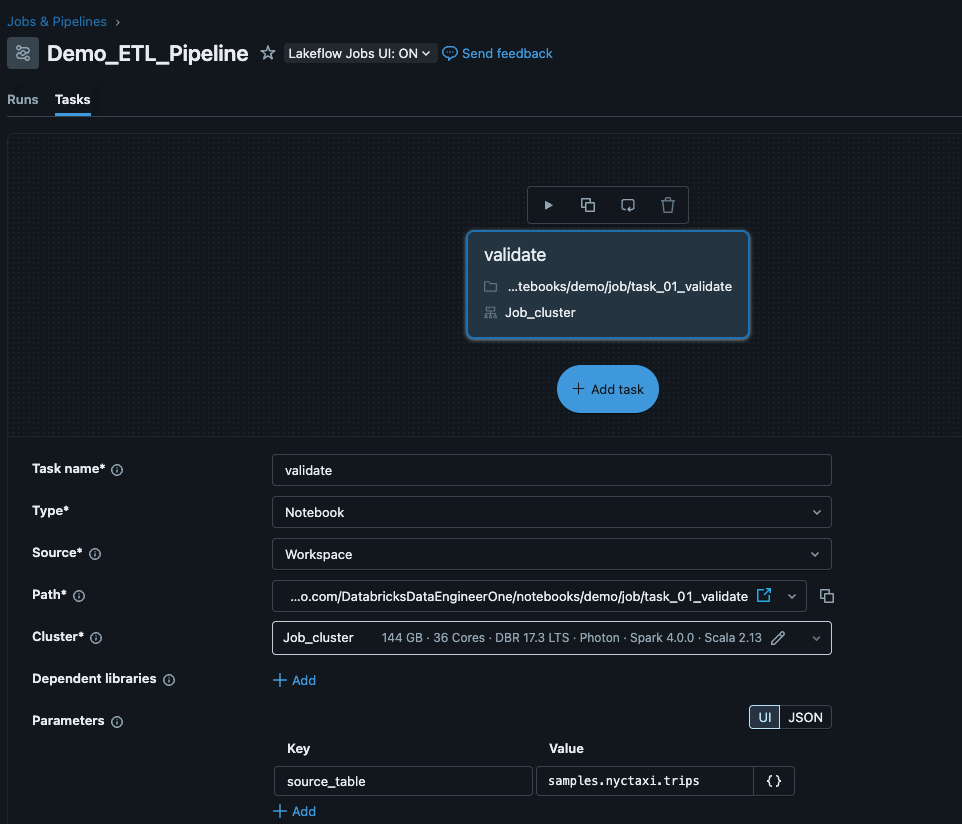
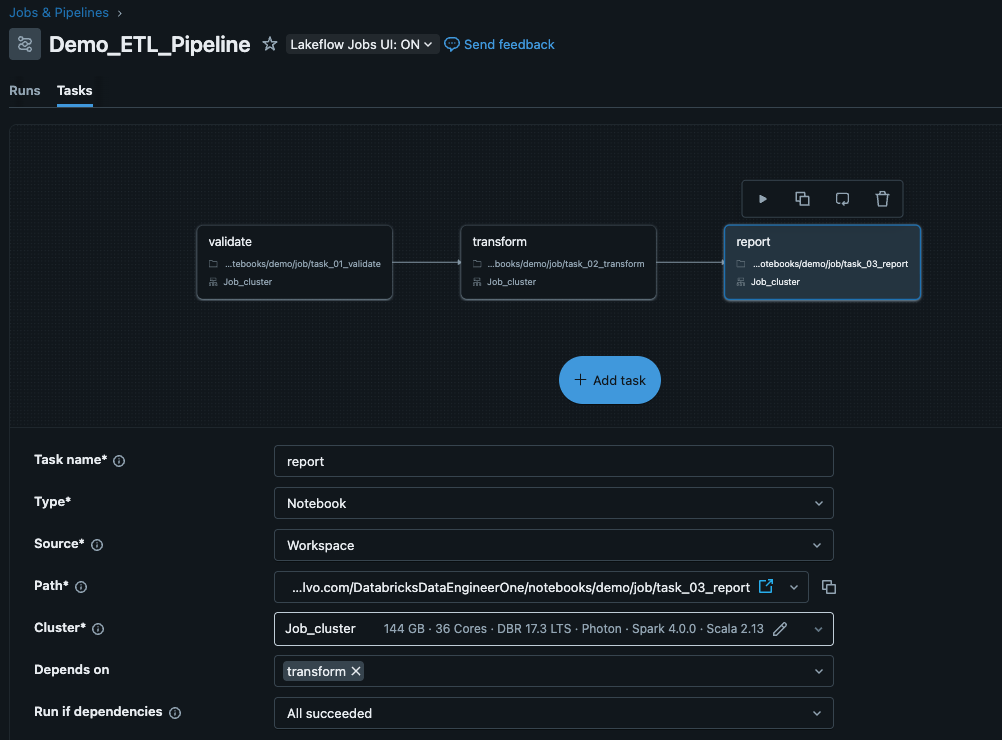

## 8.6. [UI DEMO] Triggers and Schedule


### 8.6.1. Checklist for instructor:

**Trigger Options** (Triggers tab):

| Trigger Type | Usage | Example |
|--------------|-------|---------|
| **Scheduled** | Fixed schedule | Daily at 2:00 |
| **File arrival** | Reaction to new files | New file in `/landing/` |
| **Continuous** | Continuous processing | Streaming-like |
| **Manual** | On-demand | Testing |

![Screenshot](<../../assets/images/6e23746ce063491fa8afb3dea6268a1d.png>)


**Demo: Scheduled Trigger**
- [ ] Add trigger → Scheduled
- [ ] Cron expression: `0 0 2 * * ?` (daily at 2:00)
- [ ] Timezone: `Europe/Warsaw`
- [ ] Show: Preview next runs


![alt text](<../../assets/images/cf3cfc85162a466eb77e15e20df5c15c.png>)

**Demo: File Arrival Trigger** (optional)
- [ ] Add trigger → File arrival
- [ ] URL: Unity Catalog Volume path
- [ ] Min files: 1
- [ ] Wait time: 5 minutes

### 8.6.2. Useful CRON expressions:

```
0 0 2 * * ?        # Daily at 2:00
0 0 * * * ?        # Every hour
0 0 9 ? * MON-FRI  # Mon-Fri at 9:00
0 0 0 1 * ?        # First day of month
0 */15 * * * ?     # Every 15 minutes
```

---
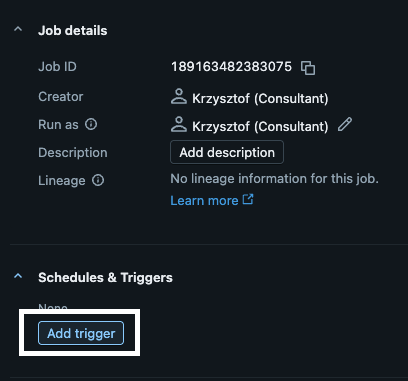

## 8.7. [UI DEMO] Options, Retry and Alerting

### 8.7.1. Checklist for instructor:

**Task-level options** (per task):
- [ ] Timeout: 30 minutes
- [ ] Retries: 2
- [ ] Retry delay: 60 seconds

**Job-level options** (top panel):
- [ ] Max concurrent runs: 1 (prevents overlap)
- [ ] Job timeout: 2 hours

**Email Notifications**:
- [ ] On failure: `team@company.com`
- [ ] On success: (optional)
- [ ] On start: (optional)

**Webhook Integration** (Slack/Teams):
- [ ] Admin Settings → Destinations
- [ ] Add webhook URL
- [ ] Assign to Job

### 8.7.2. When to use Retry?

| Scenario | Retry? | Why |
|----------|--------|-----|
| Network timeout | Yes | Transient error |
| API rate limit | Yes | Transient error |
| Data quality issue | No | Retry won't fix data |
| Code bug | No | Retry won't fix code |

---

## 8.8. Practice: Widgets and Parameters

Databricks Widgets allow you to parameterize notebooks.

---

In [0]:
# Widget types

# Text - any text
dbutils.widgets.text("environment", "dev", "Environment")

# Dropdown - select from list
dbutils.widgets.dropdown("region", "EU", ["EU", "US", "APAC"], "Region")

# Combobox - dropdown with typing option
dbutils.widgets.combobox("table", "orders", ["orders", "customers", "products"], "Table")

# Multiselect - multiple selection
dbutils.widgets.multiselect("columns", "id", ["id", "name", "date", "amount"], "Columns")

In [0]:
# Getting values
environment = dbutils.widgets.get("environment")
region = dbutils.widgets.get("region")
table = dbutils.widgets.get("table")
columns = dbutils.widgets.get("columns")  # returns comma-separated string

print(f"Environment: {environment}")
print(f"Region: {region}")
print(f"Table: {table}")
print(f"Columns: {columns}")

In [0]:
# Dynamic parameters in Job
# These values are available when notebook is run as a task in Job

dynamic_params = {
    "{{job.start_time.iso_date}}": "Run date (YYYY-MM-DD)",
    "{{job.start_time}}": "Full timestamp",
    "{{job.id}}": "Job ID",
    "{{run.id}}": "Current run ID",
    "{{task.name}}": "Current task name"
}

for param, description in dynamic_params.items():
    print(f"{param:35} -> {description}")

In [0]:
# Widget cleanup
dbutils.widgets.removeAll()

## 8.9. Practice: Passing Data Between Tasks

Two ways to pass data:

1. **dbutils.notebook.exit()** - returns value from notebook
2. **dbutils.jobs.taskValues** - reads value from previous task

---

In [0]:
# Task A - sends data
import json

result = {
    "rows_processed": 1500,
    "max_date": "2024-01-15",
    "status": "SUCCESS"
}

# Return as JSON string
# dbutils.notebook.exit(json.dumps(result))
print(f"Task A would exit with: {json.dumps(result)}")

In [0]:
# Task B - receives data from Task A
import json

# In real Job:
# task_a_output = dbutils.jobs.taskValues.get(
#     taskKey="task_a",           # name of previous task
#     key="returnValue",          # key (default "returnValue")
#     default="{}",               # default value
#     debugValue="{}"             # value for local testing
# )

# Simulation
task_a_output = '{"rows_processed": 1500, "max_date": "2024-01-15", "status": "SUCCESS"}'

data = json.loads(task_a_output)
print(f"Received from Task A:")
print(f"  Rows: {data['rows_processed']}")
print(f"  Max date: {data['max_date']}")
print(f"  Status: {data['status']}")

## 8.10. Monitoring via System Tables

Databricks provides system tables with Job run history.

---

In [0]:
spark.sql("""
    SELECT 
        *
    FROM system.lakeflow.job_run_timeline
    ORDER BY 1 DESC
    LIMIT 20
""").display()

In [0]:
spark.sql("""
    SELECT 
        DATE(period_start_time) as run_date,
        run_name as job_name,
        ROUND(
            AVG(
                (UNIX_TIMESTAMP(period_end_time) - UNIX_TIMESTAMP(period_start_time)) / 60
            ), 1
        ) as avg_duration_min,
        COUNT(*) as runs
    FROM system.lakeflow.job_run_timeline
    WHERE period_start_time >= current_date() - INTERVAL 14 DAYS
        AND result_state = 'SUCCESS'
    GROUP BY run_date, job_name
    ORDER BY run_date DESC
""").display()

## 8.11. Summary

### 8.11.1. In this module you learned:

| Topic | Key Elements |
|-------|--------------|
| **Multi-task Jobs** | DAG workflow, task dependencies |
| **Triggers** | Scheduled (CRON), File arrival, Continuous |
| **Options** | Timeout, Retry, Max concurrent runs |
| **Alerting** | Email, Webhooks (Slack/Teams) |
| **Parameters** | Widgets, dynamic values, taskValues |
| **Monitoring** | System tables, success rate, duration trends |


---